# Listing 1
## Setting up a discrete probability distribution in numpy

<BarContainer object of 51 artists>

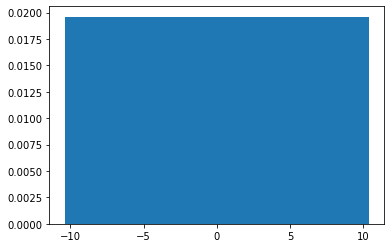

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

vmin, vmax = -10., 10. # sets the minimum and maximum values of the support of the distribution
nsup = 51 # sets up the number of elements of the support
support = np.linspace(vmin, vmax, nsup) # creates the support tensor, a tensor of evenly spaced values from -10 to +10
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support, probs) # plots the distribution as a bar plot

# Listing 2
## Updating a probability distribution

In [2]:
def update_dist(r, support, probs, lim=(-10., 10.), gamma=0.8):
    nsup = probs.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.) # calculates the support spacing value
    bj = np.round((r - vmin) / dz) # calculates the index value of the observed reward in the support
    bj = int(np.clip(bj, 0, nsup - 1)) # rounds and clips the value to make sure it is a valid index value for the support
    m = probs.clone()
    j = 1
    for i in range(bj, 1, -1): # starting from the immediate left neighbor, steals part of its probability
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1
    j = 1
    for i in range(bj, nsup - 1, 1): # starting from the immediate right neighbor, steals part of its probability
        m[i] += np.power(gamma, j) * m[i + 1]
        j += 1
    m /= m.sum() # divides by the sum to make sure it sums to 1
    return m

# Listing 3
## Redistributing probability mass after a single observation

<BarContainer object of 51 artists>

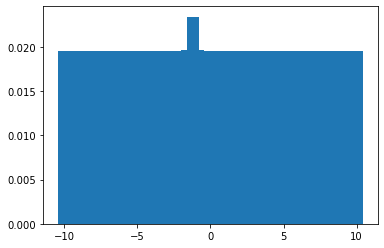

In [3]:
ob_reward = -1
Z = torch.from_numpy(probs).float()
Z = update_dist(ob_reward, torch.from_numpy(support).float(), Z, lim=(vmin, vmax), gamma=0.1)
plt.bar(support, Z)

# Listing 4
## Redistributing probability mass with a sequence of observations

<BarContainer object of 51 artists>

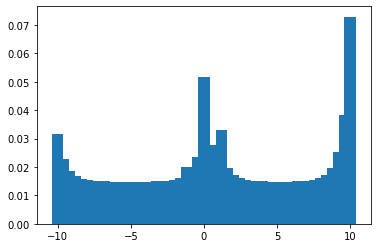

In [4]:
ob_rewards = [10, 10, 10, 0, 1, 0, -10, -10, 10, 10]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin, vmax), gamma=0.5)
plt.bar(support, Z)

# Listing 5
## Decreased variance with sequence of same reward

<BarContainer object of 51 artists>

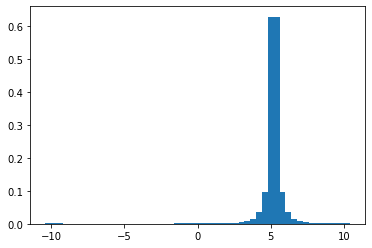

In [5]:
ob_rewards = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin, vmax), gamma=0.7)
plt.bar(support, Z)

# Listing 6
## The Dist-DQN

In [6]:
def dist_dqn(x, theta, aspace=3): # x is the 128-element vector state, theta is the parameter vector and aspace is the size of the action space
    dim0, dim1, dim2, dim3 = 128, 100, 25, 51 # defies the layer dimensions so we can unpack theta into appropriately sized matrices
    t1 = dim0 * dim1
    t2 = dim2 * dim1
    theta1 = theta[0 : t1].reshape(dim0, dim1) # unpacks the first portion of theta into the first layer matrix
    theta2 = theta[t1 : t1 + t2].reshape(dim1, dim2)
    l1 = x @ theta1 # the dimensions of this computation are B x 128 x 128 x 100 = B x 100, where B is the batch size
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 # the dimensions of this computation are B x 100 x 100 x 25 = B x 25
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace): # loops through each action to generate each action-value distribution
        step = dim2 * dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim : theta5_dim + step].reshape(dim2, dim3)
        l3_ = l2 @ theta5 # the dimensions of this computation are B x 25 x 25 x 51 = B x 51
        l3.append(l3_)
    l3 = torch.stack(l3, dim = 1) # the dimensions of the last layer are B x 3 x 51
    l3 = torch.nn.functional.softmax(l3, dim = 2)
    return l3.squeeze()

# Listing 7
## Computing the target distribution

In [7]:
def get_target_dist(dist_batch, action_batch, reward_batch, support, lim=(-10, 10), gamma=0.8):
    nsup = support.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): # loops through the batch dimension
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: # if the reward is not -1, it is a terminal state and the target is a degenerate distribution at the reward value
            target_dist = torch.zeros(nsup)
            bj = np.round((r - vmin) / dz)
            bj = int(np.clip(bj, 0, nsup - 1))
            target_dist[bj] = 1.
        else: # if the state is nonterminal, the target distribution is a Bayesian update of the prior given the reward
            target_dist = update_dist(r, support, dist, lim=lim, gamma=gamma)
        target_dist_batch[i, action, : ] = target_dist # only changes the distribution for the action that was taken
    return target_dist_batch

# Listing 8
## The cross-entropy loss function

In [8]:
def lossfn(x, y): # loss between prediction distribution x and target distribution y
    loss = torch.Tensor([0.])
    loss.requires_grad = True
    for i in range(x.shape[0]): # loops through batch dimension
        loss_ = -1 * torch.log(x[i].flatten(start_dim = 0)) @ y[i].flatten(start_dim = 0)
        loss = loss + loss_
    return loss

# Listing 9
## Testing with simulated data

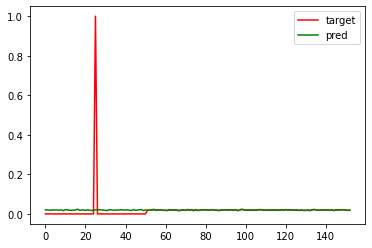

In [9]:
aspace = 3 # defines the action space to be of size 3
tot_params = 128 * 100 + 25 * 100 + aspace * 25 * 51 # defines the total number of Dist-DQN parameters based on layer sizes
theta = torch.randn(tot_params) / 10. # randomly initializes a parameter vector for Dist-DQN
theta.requires_grad = True
theta_2 = theta.detach().clone() # clones theta to use as target network
vmin, vmax = -10, 10
gamma = 0.9
lr = 0.00001
update_rate = 75 # synchronizes the main and target Dist-DQN parameters every 75 steps
support = torch.linspace(-10, 10, 51)
state = torch.randn(2, 128) / 10. # randomly initializes two states for testing
action_batch = torch.Tensor([0, 2]) # creates synthetic action data
reward_batch = torch.Tensor([0, 10]) # creates synthetic reward data
losses = []
pred_batch = dist_dqn(state, theta, aspace=aspace) # initializes a prediction batch
target_dist = get_target_dist(pred_batch, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma) # initializes a target batch

plt.plot(target_dist.flatten(start_dim = 1)[0].data.numpy(), color='red', label='target')
plt.plot(pred_batch.flatten(start_dim = 1)[0].data.numpy(), color='green', label='pred')
plt.legend()

# Listing 10
## Dist-DQN training on synthetic data

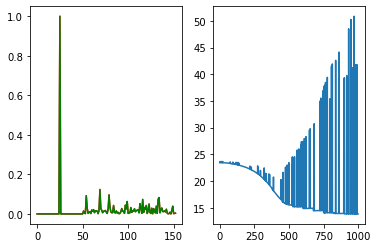

In [10]:
for i in range(1000):
    reward_batch = torch.Tensor([0, 8]) + torch.randn(2) / 10.0 # adds some random noise to the rewards to mitigate overfitting
    pred_batch = dist_dqn(state, theta, aspace=aspace) # uses the main model Dist-DQN to make distribution predictions
    pred_batch2 = dist_dqn(state, theta_2, aspace=aspace) # uses the target network Dist-DQN to make distribution predictions (using lagged parameters)
    target_dist = get_target_dist(pred_batch2, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma) # uses the target network's distributions to create the target distribution for learning
    loss = lossfn(pred_batch, target_dist.detach()) # uses the main model's distribution prediction in the loss function
    losses.append(loss.item())
    loss.backward()
    # gradient descent
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    if i % update_rate == 0: # synchronizes the target network parameters with the main model parameters
        theta_2 = theta.detach().clone()
        
fig, ax = plt.subplots(1, 2)
ax[0].plot(target_dist.flatten(start_dim = 1)[0].data.numpy(), color='red', label='target')
ax[0].plot(pred_batch.flatten(start_dim = 1)[0].data.numpy(), color='green', label='pred')
ax[1].plot(losses)

# Listing 11
## Visualizing the learned action-value distributions

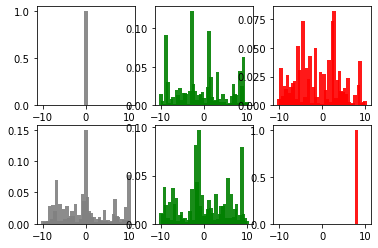

In [11]:
tpred = pred_batch
cs = ['gray', 'green', 'red']
num_batch = 2
labels = ['Action {}'.format(i, ) for i in range(aspace)]
fig, ax = plt.subplots(nrows=num_batch, ncols=aspace)

for j in range(num_batch):
    for i in range(tpred.shape[1]):
        ax[j, i].bar(support.data.numpy(), tpred[j, i, : ].data.numpy(), label='Action {}'.format(i), alpha=0.9, color=cs[i])

# Listing 12
## Preprocessing states and selecting actions

In [17]:
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state, dim=1) # normalizes state values to be between 0 and 1
    return p_state

def get_action(dist, support):
    actions = []
    for b in range(dist.shape[0]): # loops through batch dimension of distribution
        expectations = [support @ dist[b, a, : ] for a in range(dist.shape[1])] # computes the expectation values for each action-value distribution
        action = int(np.argmax(expectations)) # computes the action associated with the highest expectation value
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

# Listing 13
## Dist-DQN plays Freeway, preliminaries

In [20]:
import gym
from collections import deque

env = gym.make('Freeway-ram-v0')
aspace = 3
env.env.get_action_meanings()

vmin, vmax = -10, 10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup - 1)
support = torch.linspace(vmin, vmax, nsup)

replay = deque(maxlen=replay_size) # experience replay buffer using the deque data structure
lr = 0.0001 # learning rate
gamma = 0.1 # discount factor
epochs = 1300
eps = 0.20 # starting epsilon for epsilon-greedy strategy
eps_min = 0.05 # ending / minimum epsilon
priority_level = 5 # prioritized-replay; duplicates highly informative experiences in the replay this many times
update_freq = 25 # updates the target network every 25 steps

# initialize DQN parameter vector
tot_params = 128 * 100 + 25 * 100 + aspace * 25 * 51 # the total number of parameters for Dist-DQN
theta = torch.randn(tot_params) / 10. # randomly initializes parameters for Dist-DQN
theta.requires_grad = True
theta_2 = theta.detach().clone() # initializes parameters for target network

losses = []
rewards = [] # stores each win (successful freeway crossing) as a 1 in this list
renders = []
state = preproc_state(env.reset())

# Listing 14
## The main training loop

In [21]:
from random import shuffle

for i in range(epochs):
    pred = dist_dqn(state, theta, aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps: # epsilon-greedy action selection
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    state2, reward, done, info = env.step(action) # takes selected action in the environment
    state2 = preproc_state(state2)
    
    if reward == 1:
        rewards.append(1)
    reward = 10 if reward == 1 else reward # changes reward to +10 if environment produced reward of 1 (successful freeway crossing)
    reward = -10 if done else reward # changes reward to -10 if game is over (no crossings after a long time)
    reward = -1 if reward == 0 else reward # changes reward to -1 if original reward was 0 (game is just continuing) to penalize doing nothing
    exp = (state, action, reward, state2) # prepares experience as a tuple of the starting state, the observed reward, the action taken and the subsequent state
    replay.append(exp) # adds experience to replay memory
    
    if reward == 10: # if reward is 10, that indicates a successful crossing and we want to amplify this experience
        for e in range(priority_level):
            replay.append(exp)       
    shuffle(replay)
    state = state2
    
    if len(replay) == replay_size: # once replay buffer is full, begins training
        indx = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps], dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps], dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach(), theta, aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(), theta_2, aspace=aspace)
        target_dist = get_target_dist(pred2_batch, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma)
        loss = lossfn(pred_batch, target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        
        with torch.no_grad(): # gradient descent
            theta -= lr * theta.grad
        theta.requires_grad = True
        
    if i % update_freq == 0: # synchronizes the target network parameters to the main model parameters
        theta_2 = theta.detach().clone()
    
    if i > 100 and eps > eps_min: # decrements epsilon as a function of the epoch number
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
        
    if done: # resets the environment if the game is over
        state = preproc_state(env.reset())
        done = False

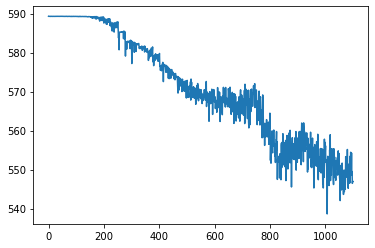

In [22]:
plt.plot(losses)